In [27]:
import Transceiver_ADRV9009_DataCollection as txvr
import ADRV9009_SquareWave_Generation as adrv9009_dac
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#### Note: I've noticed a bug that prevents me from configuring the ADRV9009 after power cycle.  
The work around is to program a param in IIO scope like the LO Frequency.  After this ADRV9009_Config() will work.

<img src="iioscope.png" alt="Drawing" style="width: 300px;">

#### Sinusoid Params:
Set the Sinusoid params here.  F_in is the desired frequency of the squarewave.  F_actual is a placeholder here.  Used to remind me that the GenerateSinewaves() class tries to access all the adc codes.  So, after creting the ideal waveform, the actual frequency is F_actual.  Make sure to either have F_LO overlap or F_in be within the bandwidth (F_LO -124.5 MHz, F_LO + 124.5MHz).  bits is the number of bits to quantize the Sinusoid Waveform.

In [28]:
F_in = 18e6
F_actual = 0
bits = 16

#### Data Generation Params:
These params have to do with generating the Sinusoid.  TX_sample_rate is the transmit sample rate and on the ADRV9009 usually 245.76e6 and equal to the RX_sample_rate

In [29]:
TX_sample_rate = 245.76e6
TX_N_samples = 256000

#### Data Collection Params
These params have to do with collecting data from the ADRV9009.  The RX_sample_rate is fixed at 245.76MHz.  F_LO is the LO frequency and should be set near F_center and within the bandwidth (245.76MHz).  RX_N_sample is the number of samples to collect.

In [30]:
RX_sample_rate = TX_sample_rate
F_LO = 750e6
RX_N_sample = 1024*100

#### HDF5:
These params have to do with collecting data from the ADRV9009.  The RX_sample_rate is fixed at 245.76MHz.  F_LO is the LO frequency and should be set near F_center and within the bandwidth (245.76MHz).  RX_N_sample is the number of samples to collect.

In [31]:
hdf5_datafile = 'adrv9009_sinusoid_test.hdf5'
hdf5_save = txvr.Collect_HDF5(hdf5_datafile = hdf5_datafile)
hdf5_save_en = True

### Make a Sinusoid and plot the ideal response

In [32]:
mysine = adrv9009_dac.GenerateSinewaves(F_in = F_in, F_sample = TX_sample_rate, bits = bits, N = TX_N_samples)

M: 18751 N:256000 Channel Spacing: 960.0 F_actual: 18000960.0


In [33]:
df_ideal_sine_params = hdf5_save.make_df_from_object_params(mysine)

In [34]:
if(hdf5_save_en == True):
    hdf5_save.save_df_to_hdf5(df_in = df_ideal_sine_params, hdf5_datafile = hdf5_datafile, title = "Ideal_Chirp_params")

saved dataframe to Ideal_Chirp_params table


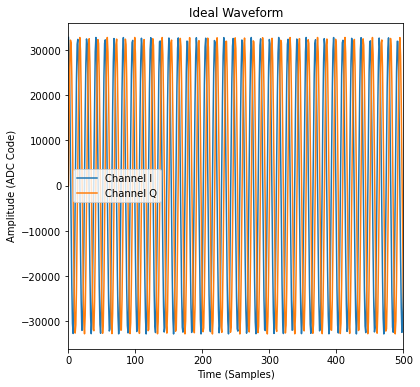

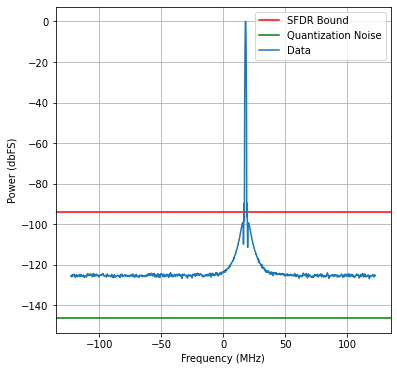

In [35]:
xf_ideal, R_dB_ideal, x_data = mysine.make_ideal_waveform(verbose=True)

### Save the Ideal Data to HDF5

In [36]:
df_ideal_data = pd.DataFrame(x_data)
if(hdf5_save_en == True):
    raw_data_array = hdf5_save.complex128_to_complexint(df_in = df_ideal_data)
    hdf5_save.save_array_data_to_hdf5(nparray_in = raw_data_array, title = "Ideal_Data")

C:\Users\mmedrano\Desktop\Waveform_Analysis\Transceiver_ADRV9009_DataCollection.py:750: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  if(nparray_in == None):


In [37]:
F_actual = mysine.F_actual

In [38]:
F_actual

18000960.0

### Configure the ADRV9009 Receiver

This class sets the params in the ADRV9009 receiver.  The rx bandwidth of the ADRV9009 defaults to 245.76 MHz, so make sure that the LO frequency is set near the chirp center frequency in the ideal chirp.  Here I have set them to F_LO MHz.

In [39]:
adrv9009_config = txvr.ADRV9009_Config(ip = "ip:192.168.1.21", f_lo = F_LO, rx_gain = 25, rx_buffer_size = RX_N_sample,
                 tx_gain = -14, calibrate_rx_phase_correction_en = 0, calibrate_rx_qec_en = 0, calibrate_tx_qec_en = 0, 
                 calibrate = 1)

### I can check the adrv9009 handle params have been set or set them directly like this:

In [25]:
#get the RX Gain:
adrv9009_config.sdr.rx_hardwaregain_chan0

25

In [26]:
#set the LO:
adrv9009_config.sdr.trx_lo = int(F_LO)
adrv9009_config.sdr.trx_lo

750000000

### Save all the adrv9009_config params to the hdf5 table

In [16]:
df_adrv9009_config_params = hdf5_save.make_df_from_object_params(adrv9009_config)
if(hdf5_save_en == True):
    hdf5_save.save_df_to_hdf5(df_in = df_adrv9009_config_params, hdf5_datafile = hdf5_datafile, title = "ADRV9009_Data_Collection_params")

saved dataframe to ADRV9009_Data_Collection_params table


In [17]:
df_adrv9009_config_params.head()

,rx_buffer_size,ip,frequency_hopping_mode,frequency_hopping_mode_en,calibrate_rx_phase_correction_en,calibrate_rx_qec_en,calibrate_tx_qec_en,calibrate,gain_control_mode_chan0,gain_control_mode_chan1,rx_hardwaregain_chan0,rx_hardwaregain_chan1,tx_hardwaregain_chan0,tx_hardwaregain_chan1,rx_rf_bandwidth,tx_rf_bandwidth,rx_sample_rate,tx_sample_rate,trx_lo
0,102400,b'ip:192.168.1.21',1700000000,0,0,0,0,1,b'manual',b'manual',25,30,-14,-10,200000000,225000000,245760000,245760000,750000000


### Get ADC data

In [18]:
data = adrv9009_config.get_ADC_data_RW(data_i = np.real(x_data), data_q = np.imag(x_data))

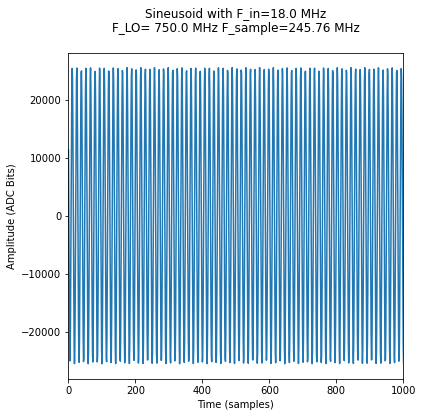

In [19]:
plt.figure(figsize = (6,6))
plt.plot(np.real(data))
plt.xlim(0,1000)
plt.ylabel("Amplitude (ADC Bits)")
plt.xlabel("Time (samples)")
plt.title("Sineusoid with F_in=" + str(F_in/1e6) + " MHz\nF_LO= " + str(F_LO/1e6) + " MHz F_sample=" + str(RX_sample_rate/1e6) + " MHz\n")
plt.show()

### Save the Raw Data to the HDF5 File

In [20]:
df_raw_data = pd.DataFrame(data)

In [21]:
if(hdf5_save_en == True):
    raw_data_array = hdf5_save.complex128_to_complexint(df_in = df_raw_data)
    hdf5_save.save_array_data_to_hdf5(nparray_in = raw_data_array, title = "Raw_Data")

C:\Users\mmedrano\Desktop\Waveform_Analysis\Transceiver_ADRV9009_DataCollection.py:750: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  if(nparray_in == None):


### Plot an FFT of the Raw Data

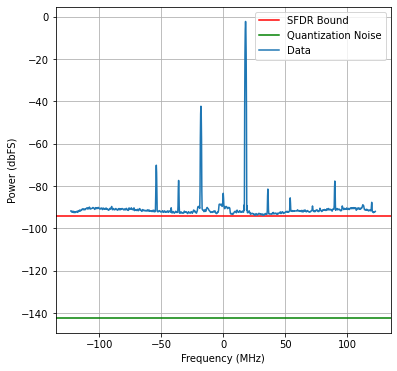

In [22]:
spur_analysis = adrv9009_dac.Quantization_Spur_Analysis(F_in = F_actual, F_sample = RX_sample_rate, bits = bits, N = len(data))
xf, R_dB, w_cg, w_ig = spur_analysis.getFFT_noise(data = data, N_t = 1024, plot_en = True)

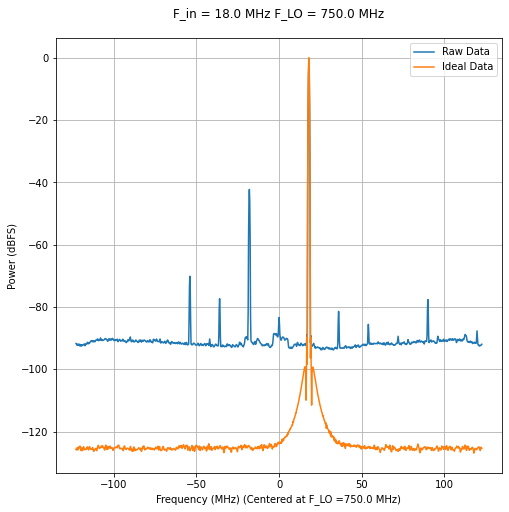

In [23]:
plt.figure(figsize = (8,8))
plt.grid()
plt.plot(xf, R_dB, label= "Raw Data")
plt.plot(xf_ideal, R_dB_ideal, label = "Ideal Data")
plt.legend()
plt.title("F_in = " + str(F_in/1e6) + " MHz F_LO = " + str(F_LO/1e6) + " MHz\n")
plt.xlabel("Frequency (MHz) (Centered at F_LO =" + str(F_LO/1e6) + " MHz)")
plt.ylabel("Power (dBFS)")
plt.savefig("Ideal_Raw_SquareWave")
plt.show()